## Check observables given a results file from a `TRSL` simulation

The purpose of this notebook is to compare some results of the `TRSL` model against real world observables in order to test the calibration.

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
filepath = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

Make file readable by `ipython` in case it was created by `pypy`:

In [4]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

KeyboardInterrupt: 

In [4]:
results = pkl.load(open(filepath))

### 0. Data overview

#### 0.1 Transcriptome:

`transcriptome_shah.p` is the best transcriptome, obtained from Premal Shah in private email (Sept 30, 2015).

In [5]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
transcriptome_shah = pkl.load(open('../parameters/transcriptome_shah.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())
print len(transcriptome_shah)
print sum(transcriptome_shah.values())

4839
60000
4839
60006


In [6]:
len(transcriptome_shah.keys())

4839

#### 0.2 Initiation rates:

Initiation rates obtained from initiation probabilities sent by Premal Shah in private email (Sept 30, 2015) and dividing by characteristic length and number of positions:

In [7]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
init_rates_plotkin_old = pkl.load(open('../parameters/init_rates_plotkin_old_2.p'))
print len(init_rates_plotkin)
print len(init_rates_plotkin_old)

4839
2569


#### 0.3 Exome:

Exome from SGD (`yeastgenome.org`)

All yeast ORFs (http://downloads.yeastgenome.org/sequence/S288C_reference/orf_dna/):

ORF Coding Sequences (CDS) only, without 5'-UTR, 3'-UTR, intron sequences, or bases not translated due to translational frameshifting, for all "Verified" and "Uncharacterized" ORFs, and transposable element genes. 

Does NOT include sequences for ORFs classified as "Dubious" or "pseudogene".

In [8]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

#### 0.4 Intersections:

Plotkin initiation rates $R$ with transcriptome $T$:

$ R \cap T$:

In [9]:
len(transcriptome_shah.viewkeys() & init_rates_plotkin.viewkeys())

4839

The two are fully overlapping (no surprise as they are both from the same file (from Premal).

Plotkin initiation rates $R$ with exome $X$:

$ R \cap X$:

In [10]:
len(orf_genomic_dict.viewkeys() & init_rates_plotkin.viewkeys())

4716

Minor discrepancies (121 genes disappearing from Premals data).

### 1. Protein production rate

In [11]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [12]:
size = 4
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

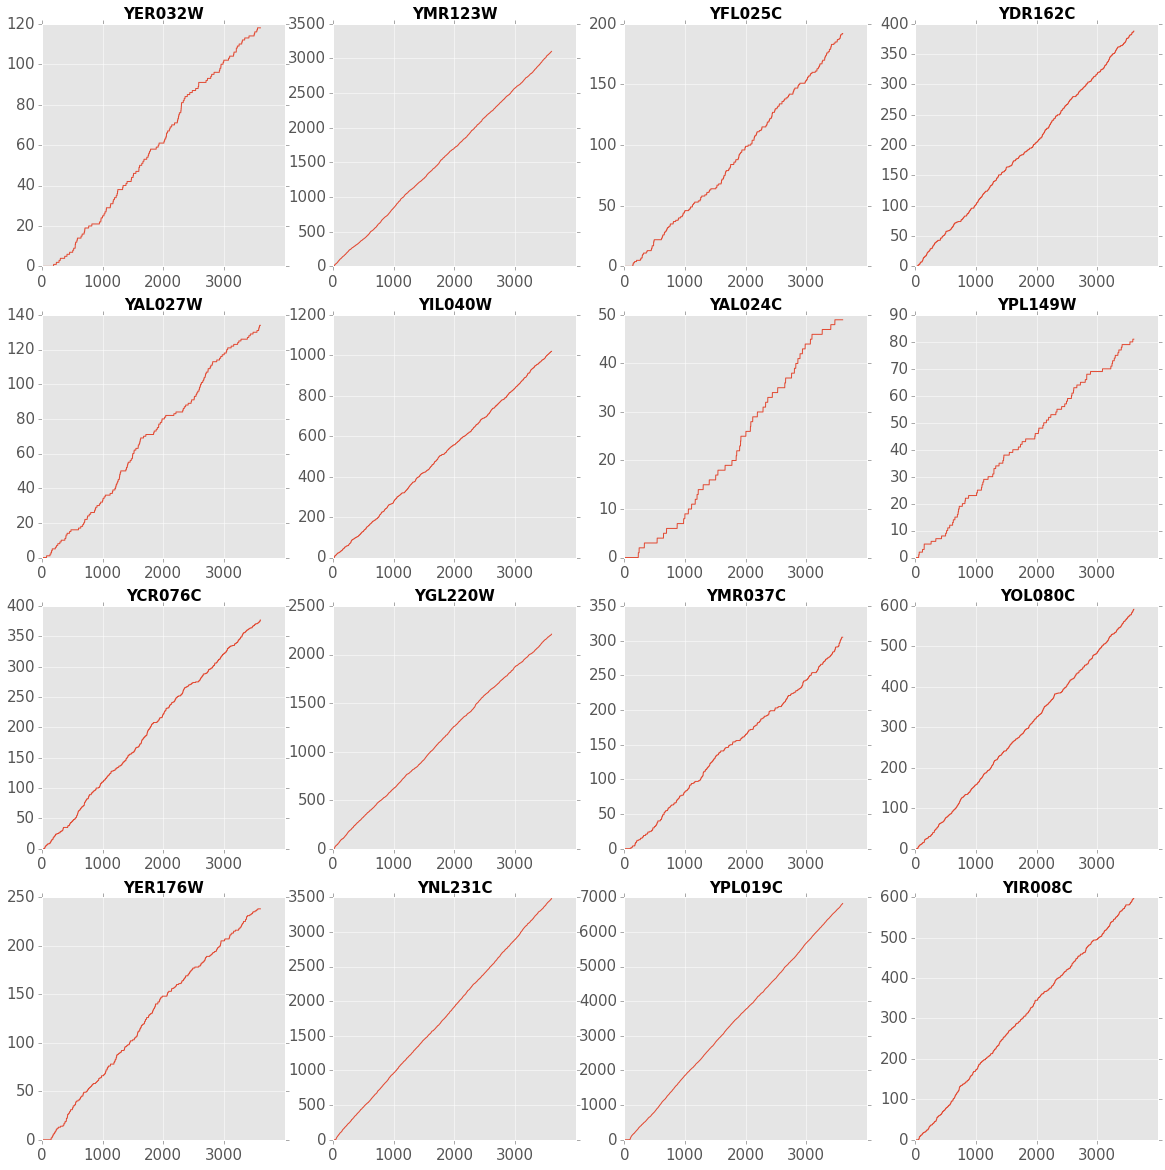

In [13]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))

for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = results['timecourses'][protnames_plot[i][j]]
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

Do the same by normalizing by transcript abundance:

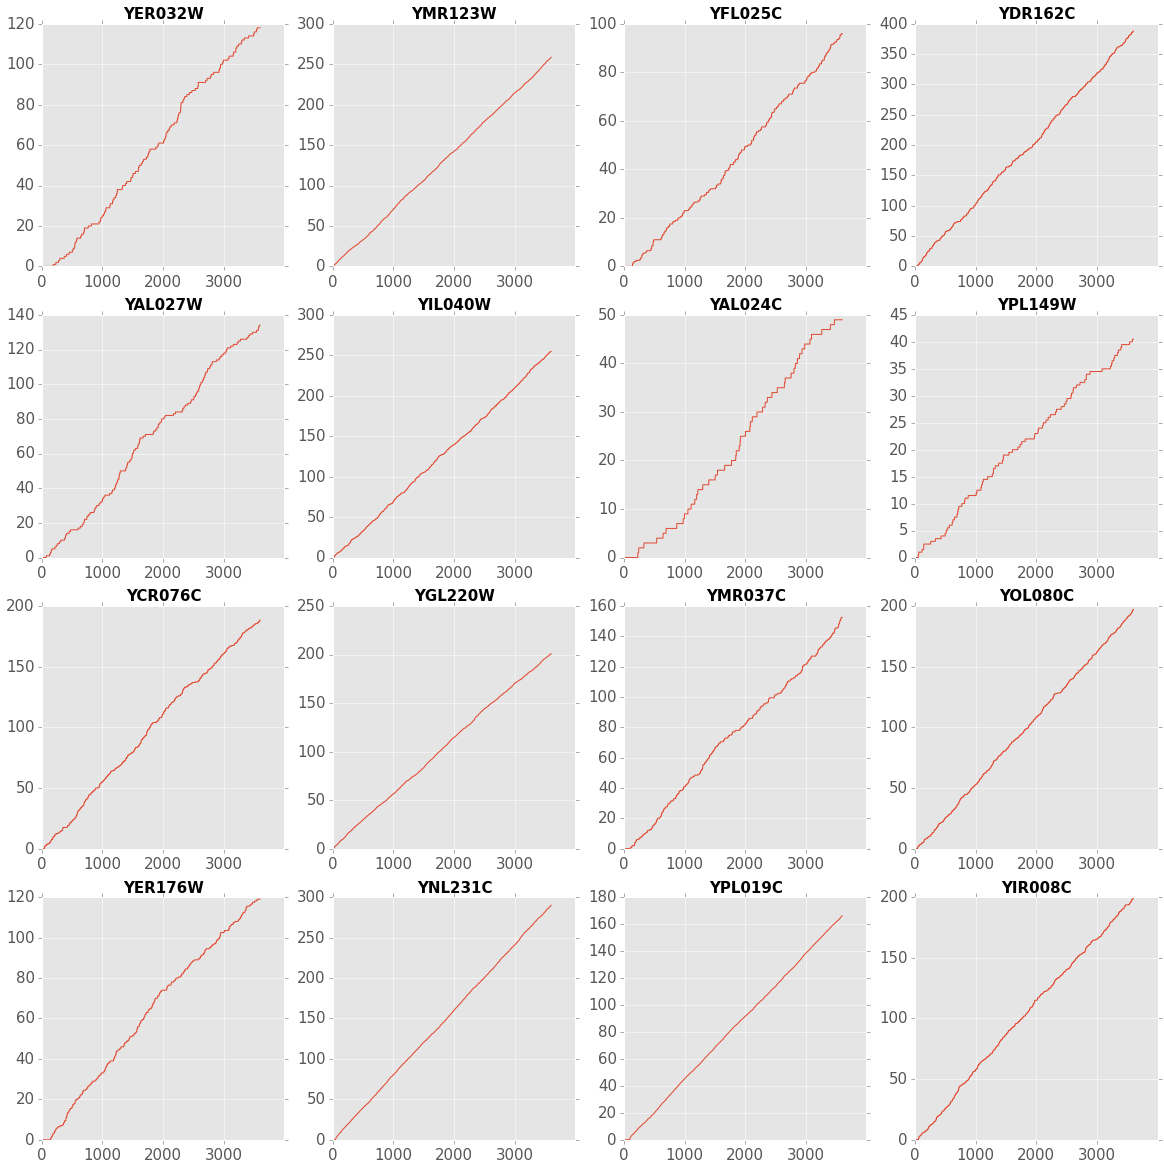

In [14]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = np.array(results['timecourses'][protnames_plot[i][j]])/(1.0*transcriptome_shah[protnames_plot[i][j]])
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 1000.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 15, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=15)

For each protein, calculate speed of translation:

In [15]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 167.580508475
YAL038W 141.609887006
YJL189W 133.568361582
YCR012W 129.352259887
YOL086C 135.939548023
YLR110C 124.482047516
YLR044C 223.223163842
YKL152C 132.904884319


In [16]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.546003
std         9.023957
min         0.001695
25%         0.055651
50%         0.140960
75%         0.431638
max       223.223164
dtype: float64

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

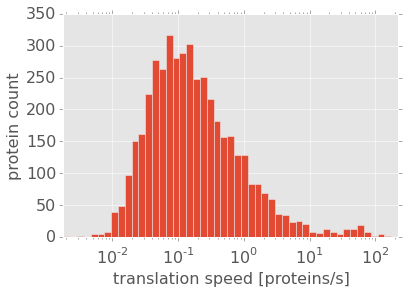

In [25]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]', fontsize=16)
plt.gca().set_ylabel('protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Three orders of magnitude. Let us check how much of this is explained by transcript abundance.

Again try the same for proteins normalized by transcript abundance (proteins/transcript/sec):

In [26]:
prot_per_transcript_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_per_transcript_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / \
        transcriptome_shah[prot] / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_per_transcript_speeds[prot] > 0.25: 
        print prot, prot_per_transcript_speeds[prot]

YJL158C 0.251702025481
YDR461W 0.267514124294
YDR224C 0.258764371875
YLR388W 0.266384180791


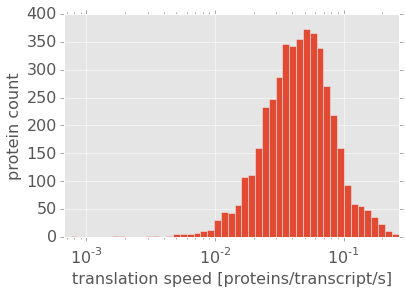

In [28]:
plt.hist(prot_per_transcript_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_per_transcript_speeds.values())+0.0001), 
                                                              np.log10(max(prot_per_transcript_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_per_transcript_speeds.values())+0.0001, max(prot_per_transcript_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/transcript/s]', fontsize=16)
plt.gca().set_ylabel('protein count', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)
plt.show()

Only one order of magnitude distribution left after division by transcript abundance.

We next compare this with experimental values by Arava et al. (http://www.pnas.org/content/100/7/3889.full):

In [29]:
prot_exp = pkl.load(open("../parameters/prot_arava.p"))
prot_exp = {gene: prot_exp[gene] for gene in prot_exp if prot_exp[gene] > 1e-16}

In [30]:
pd.Series(prot_exp).describe()

count    5643.000000
mean        0.341868
std         1.122374
min         0.000708
25%         0.038661
50%         0.102964
75%         0.257080
max        22.142236
dtype: float64

Function to plot two dictionaries by their values:

In [34]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4188


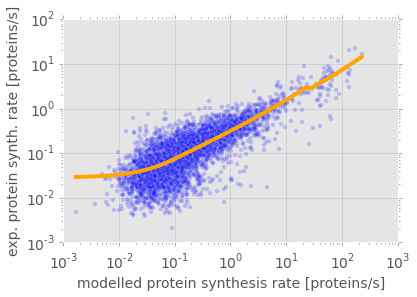

In [43]:
scatter_dicts(prot_speeds, prot_exp, "modelled protein synthesis rate [proteins/s]", \
              "exp. protein synth. rate [proteins/s]", 14)


Reasonable correlation between modelled and experimental values.

In [44]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [45]:
pd.Series(peptide_speeds.values()).describe()

count      4475.000000
mean        455.448535
std        3047.992532
min           1.508517
25%          25.654882
50%          61.476313
75%         171.086455
max      125897.864407
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second, every protein is one datapoint):

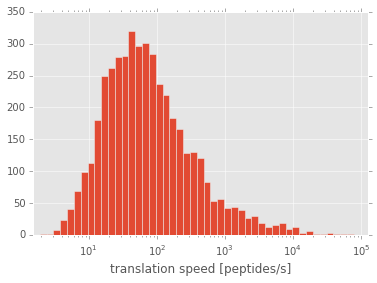

In [46]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [47]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds [bonds/second]']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates [per second]']

#df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
#df3.columns = ['name', 'transcriptome_plotkin']

df4 = pd.DataFrame.from_dict(transcriptome_shah.items())
df4.columns = ['name', 'transcript abundance']
df4 = df4[df4['transcript abundance'] >= 0.1]

In [48]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
#df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df4, left_on='name', right_on='name', how='outer')
df[:20]

,name,peptide_speeds [bonds/second],init_rates [per second],transcript abundance
0,YBR177C,160.115254,1.644214e-06,6
1,YIL140W,91.015000,1.649229e-06,2
2,YLR268W,107.378531,1.844285e-06,8
3,YOR011W,14.974999,2.686820e-07,1
4,YPL043W,330.791525,2.096261e-06,7
5,YJL155C,27.768644,1.490352e-06,1
6,YLL062C,15.974576,1.416694e-06,1
7,YIR004W,122.316384,1.514028e-06,5
8,YAL008W,58.463277,3.024409e-06,3
9,YOR043W,65.758757,7.775814e-07,5


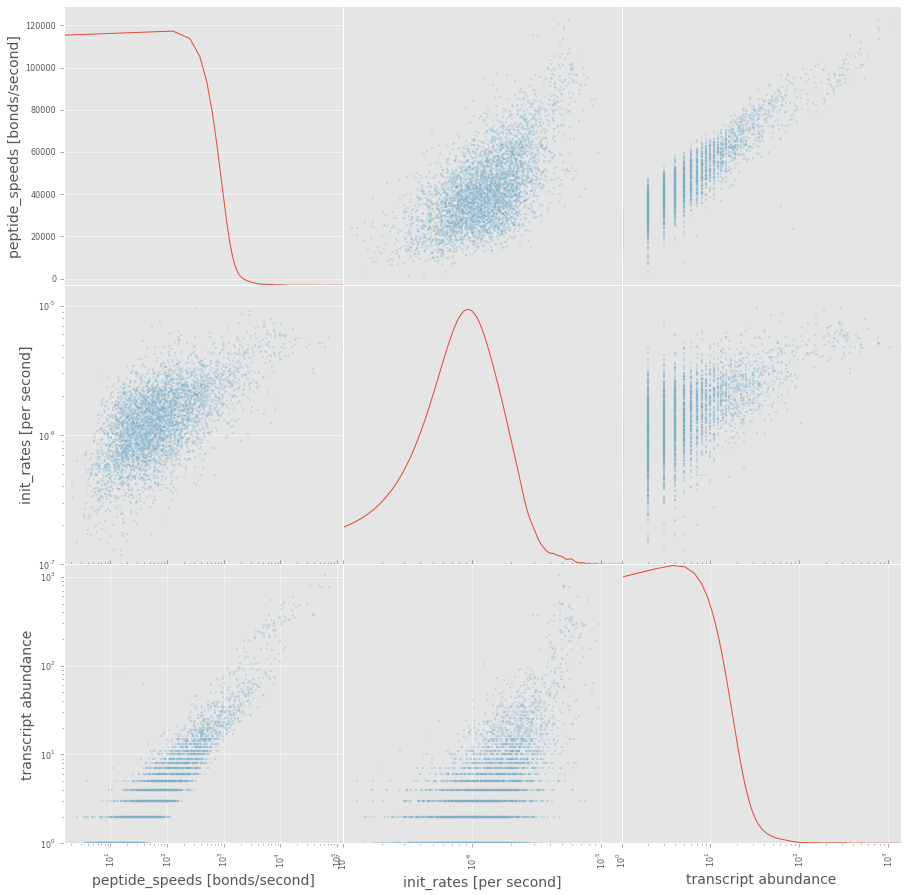

In [49]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

[plt.setp(item.yaxis.get_label(), 'size', 14) for item in axl.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', 14) for item in axl.ravel()]

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0000001, df[df.columns[i+1]].min())
        minj = max(0.0000001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.tick_params(axis='both', which='major', labelsize=14)
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')
            #ax.tick_params(axis='both', which='major', labelsize=14)

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs.

The following is smaller than 20000 (or 60000), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [50]:
len(results['transcriptome'])

57508

In [51]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [52]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [53]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [54]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [55]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [56]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [57]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [58]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [59]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [60]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [61]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

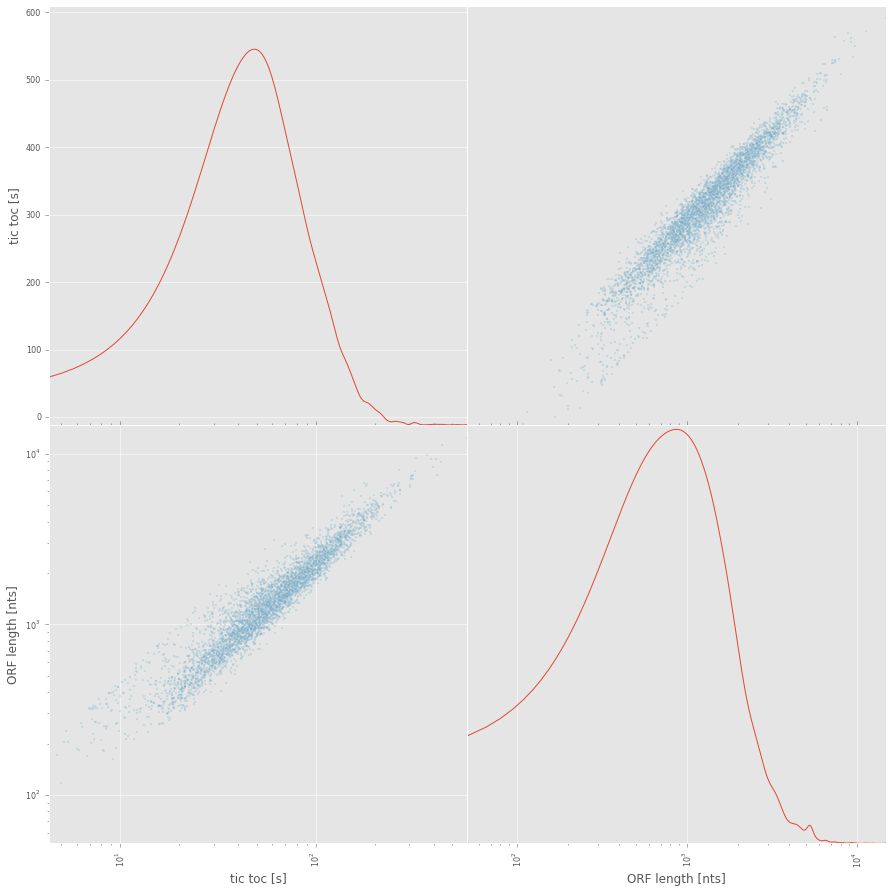

In [62]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')

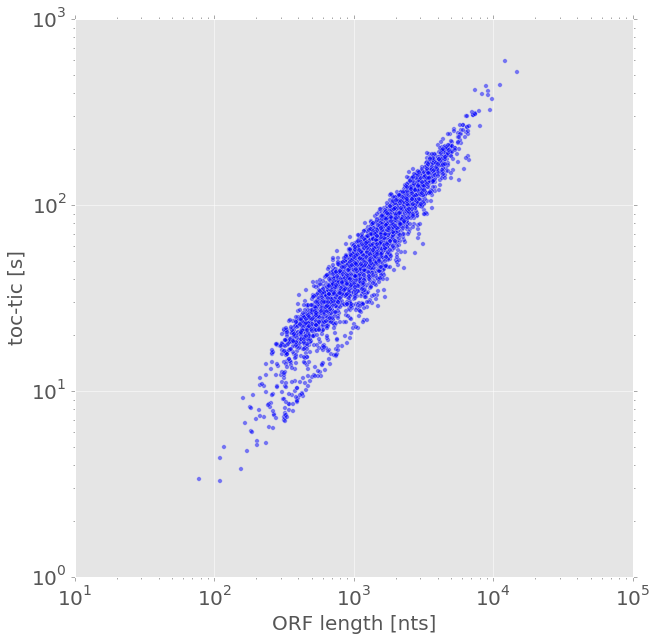

In [68]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.5)
ax.set_xlabel('ORF length [nts]', fontsize=20)
ax.set_ylabel('toc-tic [s]', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')

To account for the ORF lengths, we normalize by them:

In [69]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [70]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    4475.000000
mean        0.044198
std         0.008201
min         0.018999
25%         0.039457
50%         0.044372
75%         0.049504
max         0.080145
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   6.,   11.,   12.,   26.,   26.,   13.,   25.,   27.,   36.,
          26.,   40.,   31.,   45.,   54.,   76.,   79.,  105.,  114.,
         123.,  168.,  160.,  217.,  232.,  227.,  264.,  236.,  220.,
         234.,  237.,  206.,  193.,  173.,  152.,  138.,  101.,   96.,
          64.,   64.,   38.,   34.,   23.,   36.,   21.,   12.,   10.,
           8.,    9.,    5.,    4.,    4.,    3.,    4.,    1.,    2.,
           1.,    0.,    1.,    1.,    0.,    0.,    0.]),
 array([ 0.01899917,  0.01999917,  0.02099917,  0.02199917,  0.02299917,
         0.02399917,  0.02499917,  0.02599917,  0.02699917,  0.02799917,
         0.02899917,  0.02999917,  0.03099917,  0.03199917,  0.03299917,
         0.03399917,  0.03499917,  0.03599917,  0.03699917,  0.03799917,
         0.03899917,  0.03999917,  0.04099917,  0.04199917,  0.04299917,
         0.04399917,  0.04499917,  0.04599917,  0.04699917,  0.04799917,
         0.04899917,  0.04999917,  0.05099917,  0.05199917,  0.05299917,
    

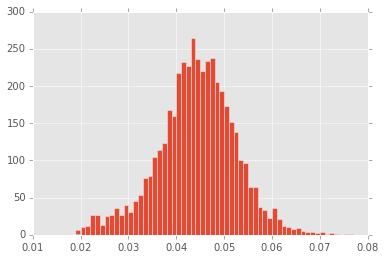

In [71]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))

In [72]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

[None, None, None, None, None, None, None, None, None]

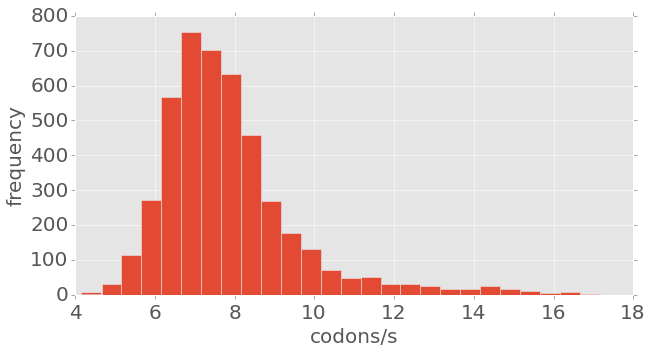

In [75]:
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))
ax.set_xlabel('codons/s', fontsize=20)
ax.set_ylabel('frequency', fontsize=20)
plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)

Broadly in line with bionumbers: 1-10 codons per second

http://bionumbers.hms.harvard.edu/search.aspx?log=y&task=searchbytrmorg&trm=ribosome+rate&time=2015%2f09%2f25+08%3a06%3a19.092

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [76]:
import shelve

filepath = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"
d = shelve.open(filepath)

Populate a dictionary with ribosome "lattices":

In [77]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [78]:
# length of longest polysome in codons
max_codons = len(max(ribo_lattice_dict.values(), key=len))

# fill up with None values
for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], \
                                        [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [79]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df[:15]

,YAL001C,YAL002W,YAL003W,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,YAL012W,YAL013W,...,YPR184W,YPR185W,YPR186C,YPR187W,YPR188C,YPR189W,YPR190C,YPR191W,YPR198W,YPR199C
0,1,0,11,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,2,0,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
4,0,0,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Check number of ribosomes in this data frame:

In [80]:
sum(dict(ribo_lattice_df.sum()).values())

162518.0

It is more convenient to remove the `None` values from `ribo_lattice_dict`:

In [81]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

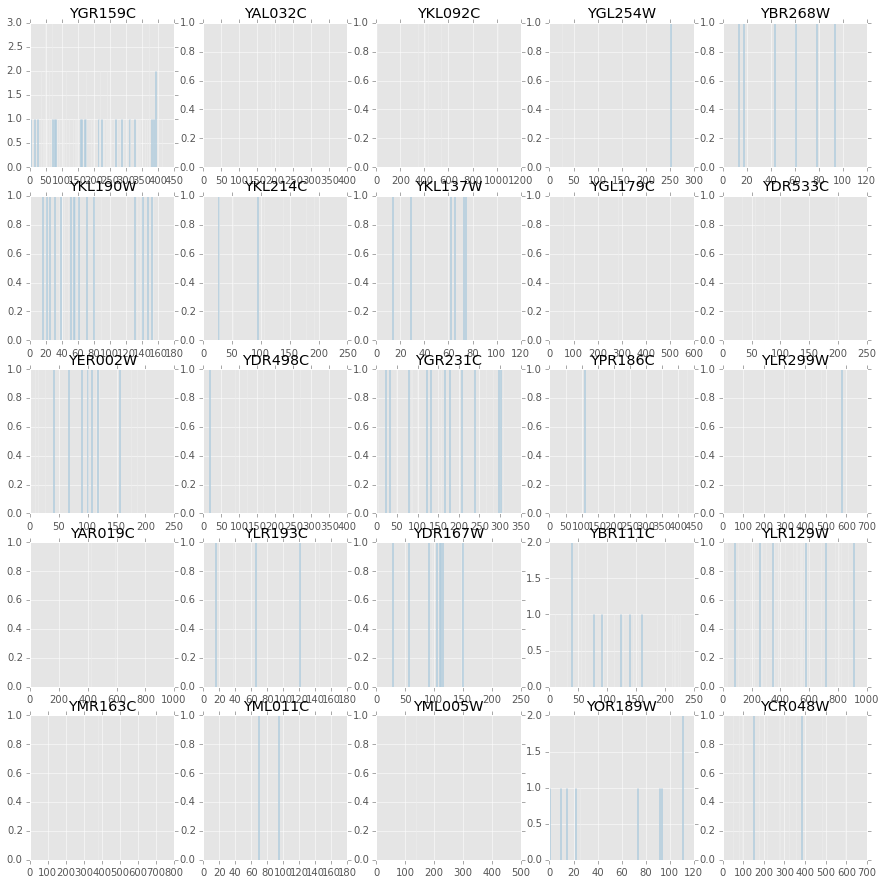

In [82]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(15, 15))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]]]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])

Average ribosome number per gene (average along the mRNA, across all codons):

In [83]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

4338


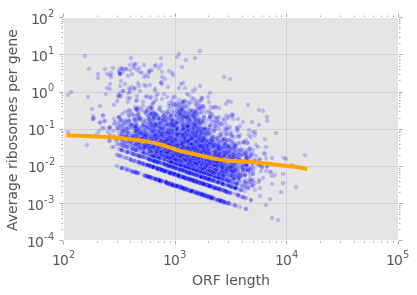

In [84]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16}, 'ORF length', 'Average ribosomes per gene', 14)

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [85]:
transcriptome = transcriptome_shah # pkl.load(open("../parameters/transcriptome_plotkin.p", "rb"))

In [86]:
print len(transcriptome)
print sum(transcriptome.values())

4839
60006


In [87]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

In [88]:
total_ribos_per_transcript = {gene: sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against ORF length:

4338


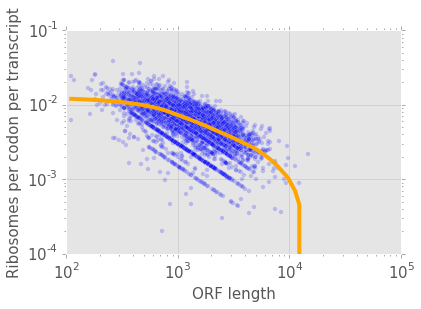

In [92]:
scatter_dicts(orf_lengths, average_ribos_per_transcript, 'ORF length', 'Ribosomes per codon per transcript', 15)

4338


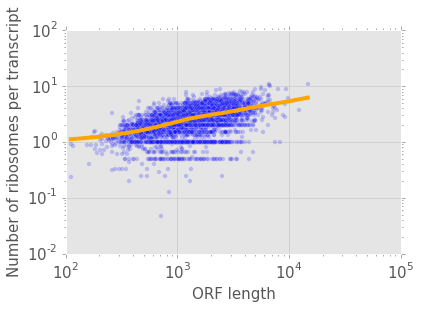

In [93]:
scatter_dicts(orf_lengths, total_ribos_per_transcript, 'ORF length', 'Number of ribosomes per transcript', 15)

This is a relatively weak dependence because shorter genes have higher initiation rates which counteracts the (expected) length effect.

Plot against initiation rate:

4338


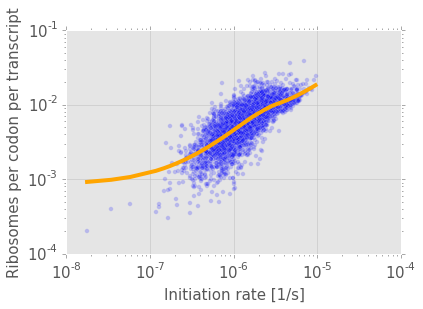

In [98]:
scatter_dicts(init_rates_plotkin, average_ribos_per_transcript, "Initiation rate [1/s]", \
              'Ribosomes per codon per transcript', 15)

In [105]:
1/np.mean(average_ribos_per_transcript.values())

152.89746635095389

2492


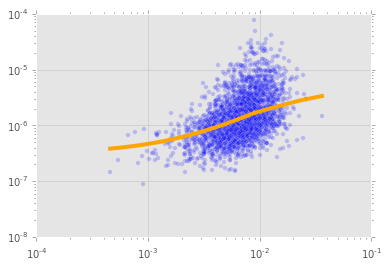

In [106]:
scatter_dicts(average_ribos_per_transcript, init_rates_plotkin_old)

4716


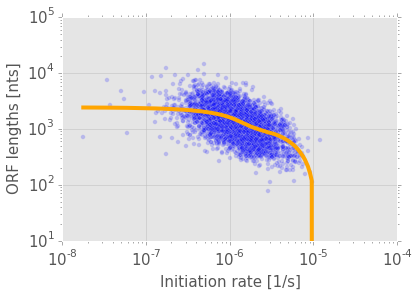

In [107]:
scatter_dicts(init_rates_plotkin, orf_lengths, "Initiation rate [1/s]", \
              "ORF lengths [nts]", 15)

TODO: what explains the remaining dispersion? TODO: check CAI?

Analysis by codon position:

In [108]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [114]:
means_per_position = ribo_lattice_df_normalized.mean(axis=1, numeric_only=None)
means_per_position

0       0.008944
1       0.005518
2       0.006581
3       0.005952
4       0.006344
5       0.007135
6       0.007974
7       0.007150
8       0.007303
9       0.007234
10      0.006592
11      0.007052
12      0.006371
13      0.006670
14      0.008482
15      0.007299
16      0.006746
17      0.007670
18      0.006915
19      0.007316
20      0.006499
21      0.007164
22      0.006914
23      0.006362
24      0.008135
25      0.007088
26      0.006298
27      0.007457
28      0.005821
29      0.007282
          ...   
4881    0.000000
4882    0.000000
4883    0.000000
4884    0.000000
4885    0.000000
4886    0.000000
4887    0.000000
4888    0.000000
4889    0.000000
4890    0.000000
4891    0.000000
4892    0.000000
4893    0.000000
4894    0.000000
4895    0.000000
4896    0.000000
4897    0.000000
4898    0.000000
4899    0.000000
4900    0.000000
4901    0.000000
4902    0.000000
4903    0.000000
4904    0.000000
4905    0.000000
4906    0.000000
4907    0.000000
4908    0.0000

In [116]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
positions

4911

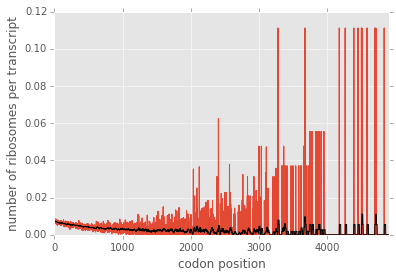

In [117]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
#plt.xlim([0, 500])
#plt.ylim([0, 0.01])
#plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

[None, None, None, None, None, None]

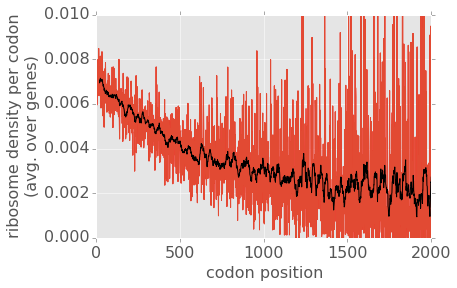

In [122]:
ts = means_per_position

ts.plot(style='r').set_xlabel('codon position', fontsize=16)
ts.plot().set_ylabel('ribosome density per codon\n(avg. over genes)', fontsize=16)
pd.rolling_mean(ts, 20).plot(style='k')

ax = plt.subplot(111)
ax.set_xlim([0.0, 2000.0])
ax.set_ylim([0.0, 0.01])
plt.setp(plt.gca().get_xticklabels(), fontsize=16)
plt.setp(plt.gca().get_yticklabels(), fontsize=16)

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [123]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 1381)

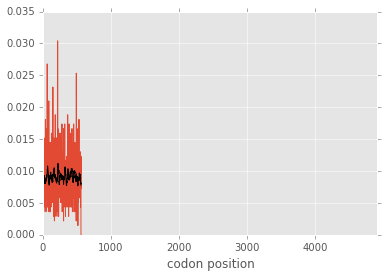

In [124]:
ribo_lattice_df_normalized[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df_normalized[maxgene], 20).plot(style='k')

No ribosome ramp at individual gene level? This would be consistent with Shah's hypothesis that it is caused by short genes with high initiation probabilities. 

TODO: we need to check this more systematically.

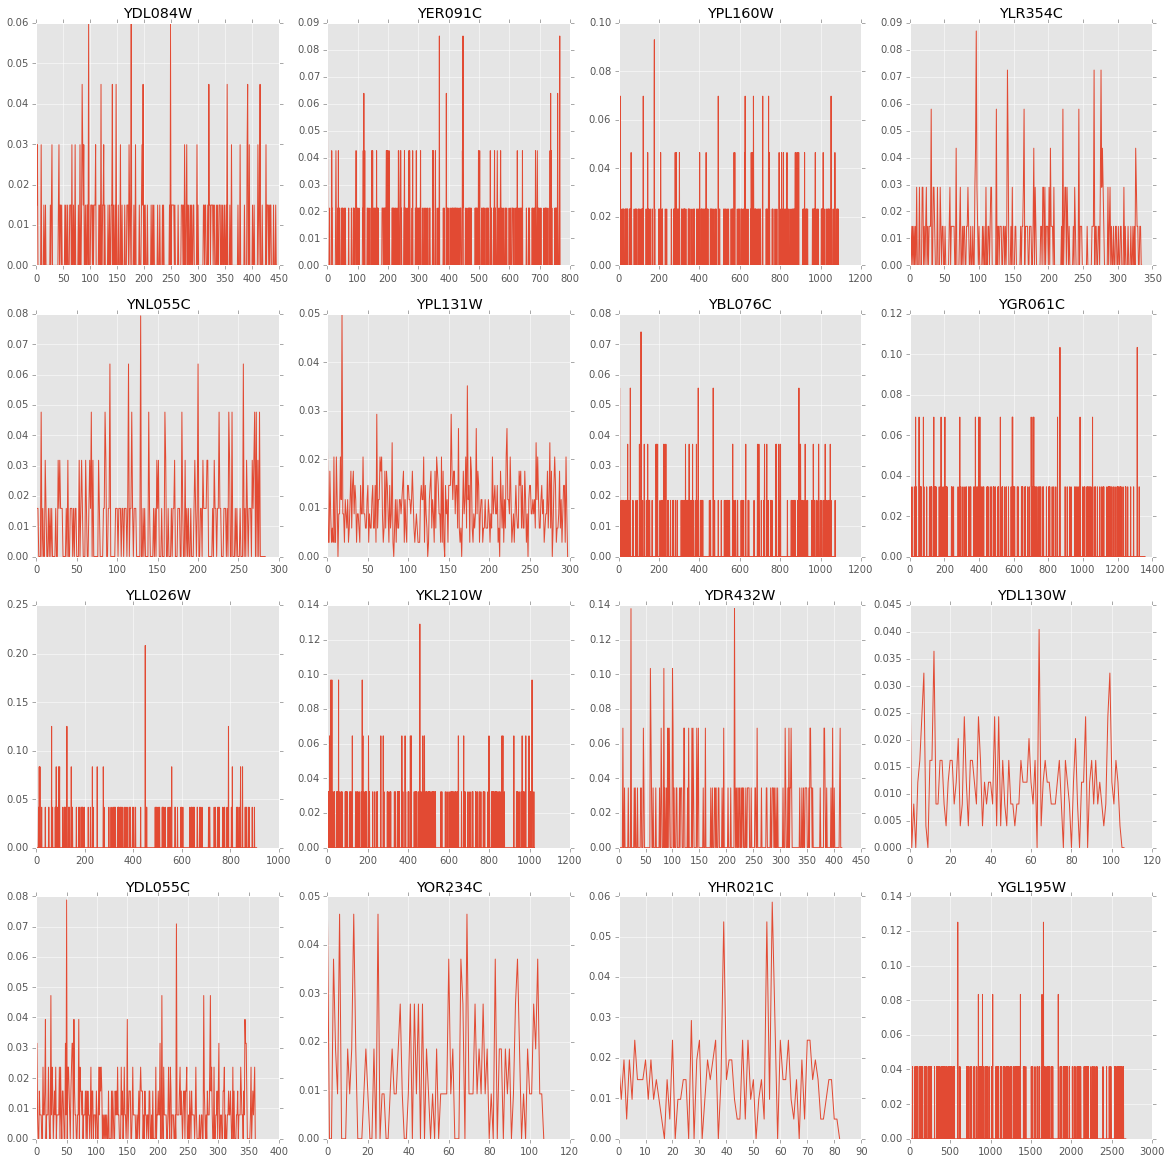

In [125]:
high_transcript_abundance_genes = [gene for gene in ribo_lattice_dict 
                                   if sum([elem for elem in ribo_lattice_dict[gene]]) > 150]

size = 4
genenames_plot = np.array(random.sample(high_transcript_abundance_genes, size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].plot(ribo_lattice_df_normalized[genenames_plot[i][j]])
        #ax[i, j].set_xlabel('codon position')
        ax[i, j].set_title(genenames_plot[i][j])

To calculate the SNR, we establish standard deviations and maxima of the ribosome densities:

In [126]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}
means = {gene: np.mean(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

Find all peaks where the signal to noise ratio is greater than a predefined threoshold:

In [127]:
threshold = 5  # this many standard deviations above the mean are required for a signal to be classified as a peak

peaks = {gene: [(pos, value, (value - means[gene]) / sigmas[gene]) for (pos, value) 
                in enumerate(ribo_lattice_df_normalized[gene]) if (value - means[gene]) / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
         }
        # and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [128]:
peaks['YDL130W'], peaks['YBR078W']

([], [(410, 0.11904761904761904, 8.2102831036983535)])

Find out which codons are typically at peaks (hypothesis is that these might be rare codons):

In [129]:
from translation.TRSL_specific import codon_anticodon, tRNA_types, chunker, complement

In [130]:
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}

In [131]:
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

Define auxiliary function:

In [132]:
from itertools import chain

def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

In [133]:
from collections import Counter

counter = Counter(flatten_dict_values(anticodons_at_peaks))

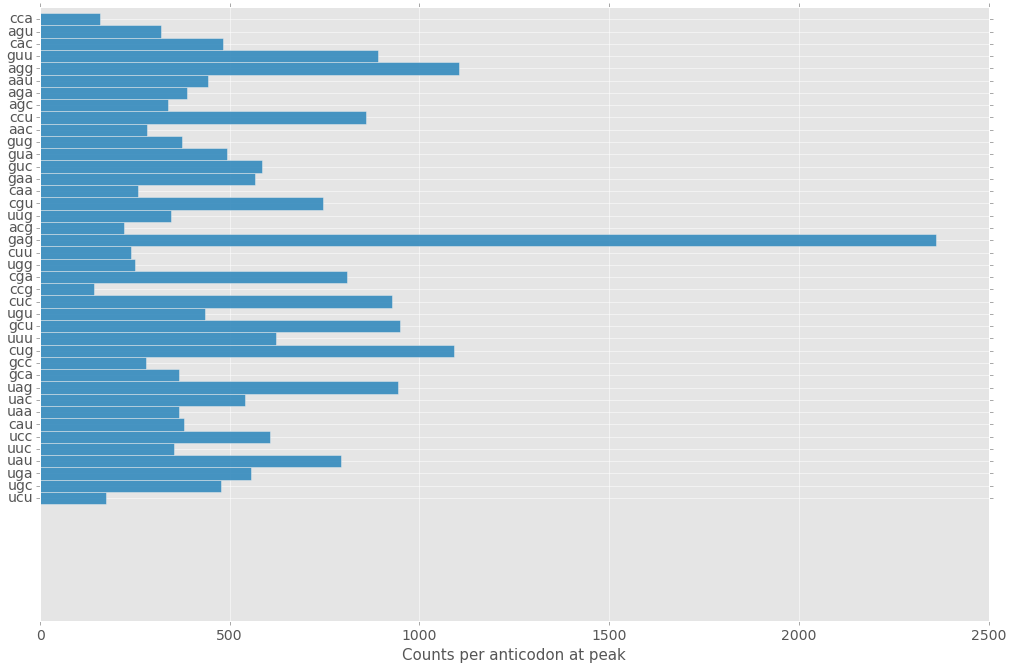

In [138]:
keys = counter.keys()
y_pos = np.arange(len(keys))*5

# get the counts for each key, assuming the values are numerical
counts = counter.values()

plt.figure(figsize=(17, 11))
plt.barh(y_pos, counts, align='center', height=5, alpha=0.9)
plt.yticks(y_pos, keys)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Counts per anticodon at peak', fontsize=15)
plt.show()

TODO: does this become more pronounced if restricted to high abundance proteins?

In [140]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

40


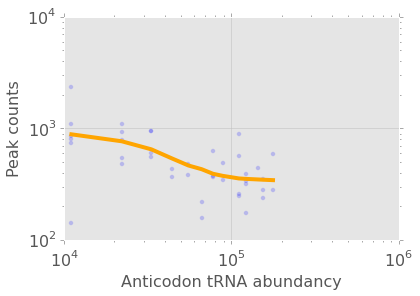

In [141]:
scatter_dicts(anticodon_tRNA_abundancy, counter, "Anticodon tRNA abundancy", "Peak counts", 16)

The more tRNAs are available for an anticodon, the fewer peaks happen at these anticodons. Note the log axes.

Anticodon frequency at peaks compared to overall anticodon frequency in _transcriptome_:

The following list contains mRNA sequences times their occurrence in the transcriptome:

In [142]:
transcriptome_weighted_orfs = [orf_genomic_dict[gene] * transcriptome[gene] for gene in transcriptome 
                               if gene in orf_genomic_dict]

These must be converted to anticodons:

In [143]:
anticodon_demand_transcriptome = Counter([codon_anticodon[item] for sublist in [list(chunker(sequence, 3)) 
                                          for sequence in transcriptome_weighted_orfs] 
                                              for item in sublist])
anticodon_demand_transcriptome

Counter({'agc': 1345244, 'guc': 1258708, 'uuc': 1218385, 'aau': 1187231, 'aac': 1175494, 'gcc': 1162068, 'guu': 1100842, 'cuu': 1025306, 'aga': 995101, 'agu': 950959, 'caa': 919197, 'gaa': 911064, 'gua': 698588, 'uuu': 650012, 'uug': 641345, 'ugg': 632380, 'ucu': 624262, 'uaa': 467920, 'gug': 443567, 'cau': 441740, 'uag': 338330, 'ugc': 323414, 'gcu': 304681, 'agg': 303015, 'cuc': 279884, 'uga': 235840, 'ugu': 229125, 'cca': 224021, 'gca': 223945, 'acg': 211083, 'ucc': 208235, 'gag': 203602, 'uau': 175159, 'cac': 155937, 'cug': 149490, 'uac': 143880, 'ccu': 107587, 'cga': 99555, 'cgu': 90024, '*': 57508, 'ccg': 12669})

41


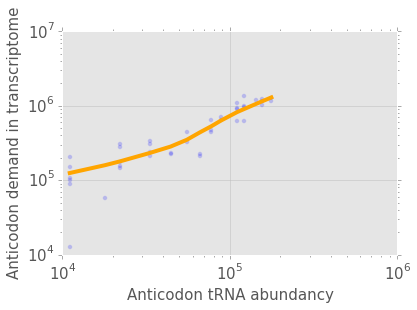

In [144]:
scatter_dicts(anticodon_tRNA_abundancy, anticodon_demand_transcriptome, "Anticodon tRNA abundancy", \
              "Anticodon demand in transcriptome", 15)

This is model-free, i.e. only transcriptome vs abundancies.

40


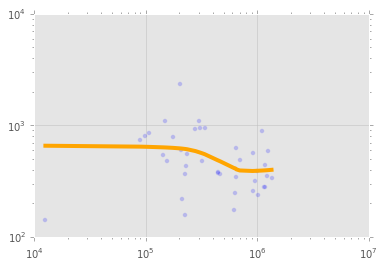

In [101]:
scatter_dicts(anticodon_demand_transcriptome, counter)

### 4. Number of free ribosomes

(0, 70000)

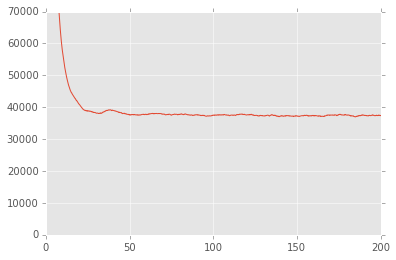

In [102]:
plt.plot(results["timerange"], results["timecourses"]["ribos._free"])
plt.xlim([0, 200])
plt.ylim([0, 70000])

There is a slight oscillation visible at the beginning that washes out towards the end.

In [133]:
results["timecourses"]["ribos._free"][-1] / 200000.

0.18741

19 % free ribosomes. (Shah et al. paper has 15%.)